# Nutrition, Physical Activity, and Obesity Analysis

**Project Description**  
This project explores the relationship between adults' diet, physical activity, weight status, and obesity levels using data from the Behavioral Risk Factor Surveillance System. The aim is to identify patterns and predictors of obesity in the adult population to inform public health strategies.  
**Problem Statement**  
The project aims to predict obesity levels in the adult population based on various factors, including diet, physical activity, and weight status. As well as identify different at risk groups. 
**Type of Learning**  
This is a Supervised Learning project, as we will be using labeled data to train our models to predict the obesity level, a categorical outcome based on input features.  
**Algorithms and Models**  
We will explore several machine learning algorithms both supervised and unsupervised to find the most effective model for our task. The models we will use are the Support Vector Machine (SVM) model, Gradient Boosting Regressor and K-Means clustering. We will also be using hyperparameter tuning on the Gradient Boosting Regressor model. 
**Type of Task**  
There are two primary goals one is Classification, where the goal is to categorize individuals into obesity levels based on the input features. And the other is to potentially identify clusters of groups in the population with different health problems.

### Data Source and Citation

**Dataset**: Nutrition, Physical Activity, and Obesity  
**Author**: Matt OP  
**Data Retrieved from**: [Data.gov Catalog](https://catalog.data.gov/dataset)  
**Kaggle Dataset URL**: [Nutrition, Physical Activity, and Obesity](https://www.kaggle.com/datasets/mattop/nutrition-physical-activity-and-obesity)  
**License**: CC0: Public Domain

#### About
This dataset includes data on adult's diet, physical activity, and weight status from Behavioral Risk Factor Surveillance System. This data is used for DNPAO's Data, Trends, and Maps database, which provides national and state specific data on obesity, nutrition, physical activity, and breastfeeding.

#### Citation (APA Style)
Matt OP. (2023). Nutrition, Physical Activity, and Obesity [Data set]. Kaggle. Retrieved from https://www.kaggle.com/datasets/mattop/nutrition-physical-activity-and-obesity. Data originally sourced from [Data.gov Catalog](https://catalog.data.gov/dataset).ov/dataset).
et).ov/dataset).

### Data Description & Cleaning
This dataset is in tabular form and was gathered from a single source.  
There are over 33 Features, some of the key ones are Age, Gender, Income, and Education.  
The number of samples is 88,629.  
Some of the data needed to be mapped and the stratifications needed to be pivoted to create correlation matrices.

**Handling Missing Values**  
Calculate missing values, then calculate the percentage of missing values, then drop every column with more than 50% of the data missing.  
**Removing Redundant Features**  
Since every YearEnd and YearStart are the same we are just going to replace it with Year.  
Similarly data_value and data_value_alt are the same.  
**Removing Outliers**  
Removed any data points that fell outside of the inner quartiles.  
**Little Note**  
Got error: "use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead."  
Also converted all the inf to NaN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
file_path = 'Data/Nutrition__Physical_Activity__and_Obesity.csv'
data = pd.read_csv(file_path)
data_cleaned = data

#Handling Missing Values
na_values = pd.DataFrame(data.isna().sum(), columns=['Total Values Null'])
na_values['%_weight'] = na_values['Total Values Null'].apply(lambda x: x / data.shape[0] * 100)
drop_na_columns = na_values[na_values['%_weight'] > 50].index
data_cleaned = data.drop(columns=drop_na_columns)

#Removing Redundant Features
data_cleaned.drop('YearEnd', axis=1, inplace=True)
data_cleaned.rename(columns={'YearStart': 'Year'}, inplace=True)
data_cleaned.drop('Data_Value_Alt', axis=1, inplace=True)

#Removing Outliers
Q1 = data_cleaned['Data_Value'].quantile(0.25)
Q3 = data_cleaned['Data_Value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data_cleaned = data_cleaned[(data_cleaned['Data_Value'] >= lower_bound) & (data_cleaned['Data_Value'] <= upper_bound)]

#Little Note
data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
warnings.filterwarnings('ignore', category=FutureWarning)

**Data Mapping**

In [3]:
age_mapping = {
    'AGEYR1824': 1, 'AGEYR2534': 2, 'AGEYR3544': 3, 'AGEYR4554': 4, 'AGEYR5564': 5, 'AGEYR65PLUS': 6,
}
education_mapping = {
    'EDUHS': 1, 'EDUHSGRAD': 2, 'EDUCOTEC': 3, 'EDUCOGRAD': 4,
}
income_mapping = {
    'INCLESS15': 1, 'INC1525': 2, 'INC2535': 3, 'INC3550': 4, 'INC5075': 5, 'INC75PLUS': 6, 'INCNR': 7,
}

combined_mapping = {**age_mapping, **education_mapping, **income_mapping}

questions_data = {
    "Q047": "Percent of adults who engage in no leisure-time physical activity",
    "Q036": "Percent of adults aged 18 years and older who have obesity",
    "Q037": "Percent of adults aged 18 years and older who have an overweight classification",
    "Q045": "Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity",
    "Q046": "Percent of adults who engage in muscle-strengthening activities on 2 or more days a week",
    "Q018": "Percent of adults who report consuming fruit less than one time daily",
    "Q043": "Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity",
    "Q019": "Percent of adults who report consuming vegetables less than one time daily",
    "Q044": "Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity and muscle-strengthening activities"
}

In [4]:
stratification_mappings = {
    'Stratification1': {**age_mapping, **education_mapping, **income_mapping}
}
data_cleaned.replace(stratification_mappings, inplace=True)
data_pivoted = data_cleaned.pivot_table(index=['Year', 'LocationAbbr', 'LocationDesc'],
                                        columns=['QuestionID'],
                                        values='Data_Value').reset_index()


### Exploratory Analysis ###
I chose to use histograms and correlation matrices because histograms provide a good visualization for the distribution of different
health related behavaiors across a population. The correlation matrices on the other hand are able to indentify different predictors for health outcomes. For instance, there were negative correlations in question 47 which could indicate that people with higher education in general have lower rates of leisure time. Also there is a slight positive correlation between higher income levels and higher rates of overweight classification. In general all of the age, education and income play roles in influencing healthy or unhealathy behaviors. One thing that is difficult with data dealing with socioeconomic factors which all interact with eachother, is that there can be a substantial amount of missing data and reporting biases.

**Histograms**

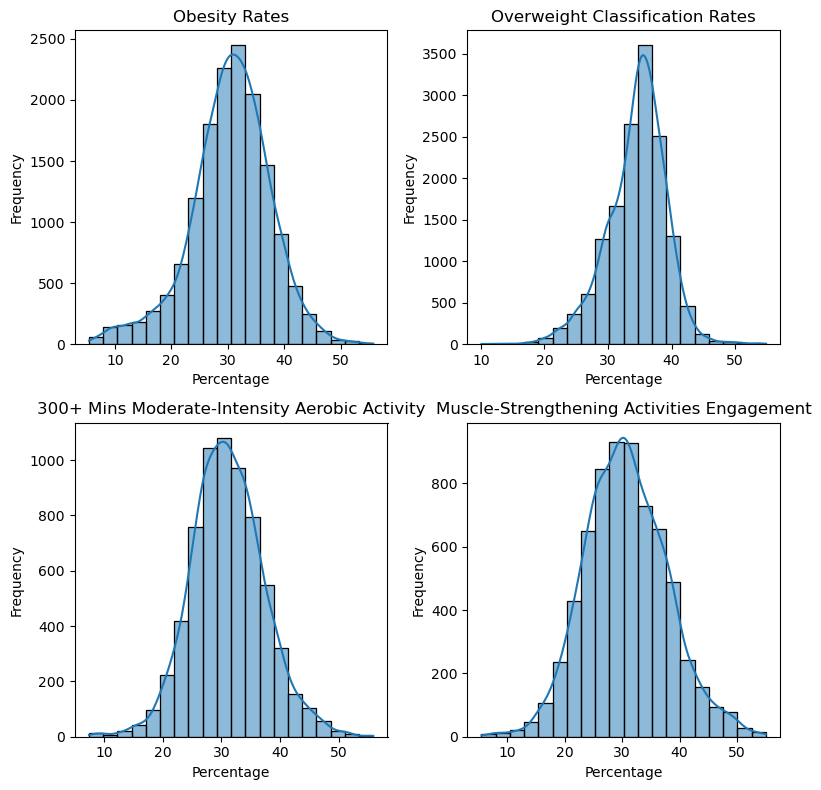

In [5]:
questions_of_interest = ["Q036", "Q037", "Q045", "Q046"]

question_titles = {
    "Q036": "Obesity Rates",
    "Q037": "Overweight Classification Rates",
    "Q045": "300+ Mins Moderate-Intensity Aerobic Activity",
    "Q046": "Muscle-Strengthening Activities Engagement"
}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
axes = axes.flatten()

for idx, question_id in enumerate(questions_of_interest):
    data_filtered = data_cleaned[data_cleaned['QuestionID'] == question_id]
    
    sns.histplot(data_filtered['Data_Value'], bins=20, kde=True, ax=axes[idx])
    axes[idx].set_title(question_titles[question_id])
    axes[idx].set_xlabel('Percentage')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Correlation Matrices**  

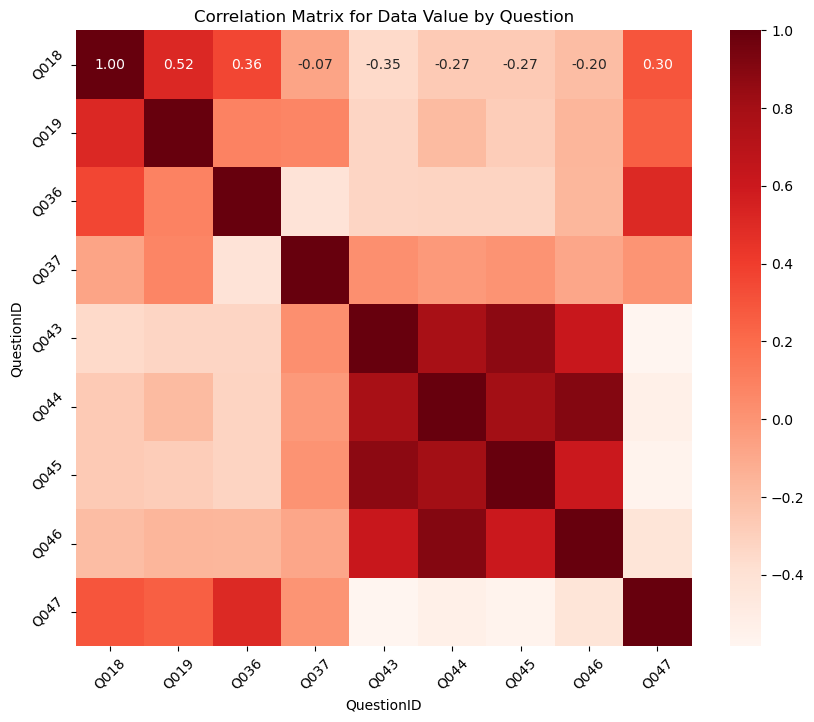

In [6]:
data_pivoted_numeric = data_pivoted.drop(['Year', 'LocationAbbr', 'LocationDesc'], axis=1)
data_pivoted_numeric = data_pivoted_numeric.fillna(data_pivoted_numeric.mean())
correlation_matrix = data_pivoted_numeric.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Reds", cbar=True, square=True)
plt.title('Correlation Matrix for Data Value by Question')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

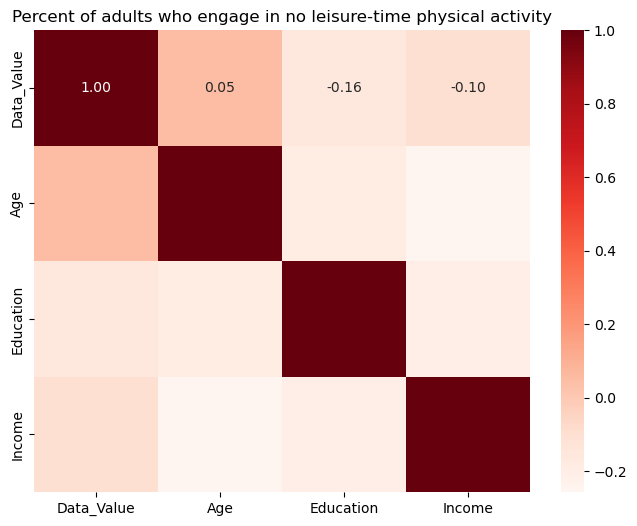

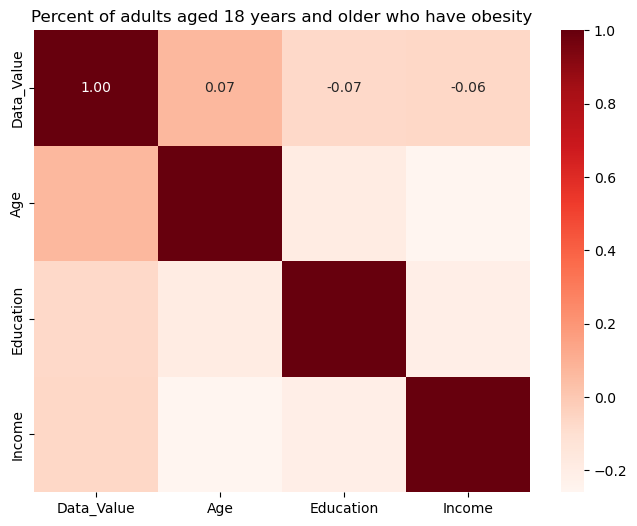

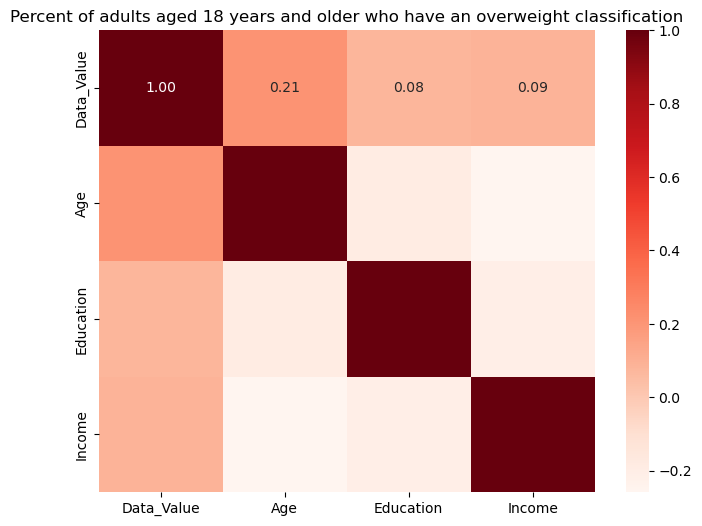

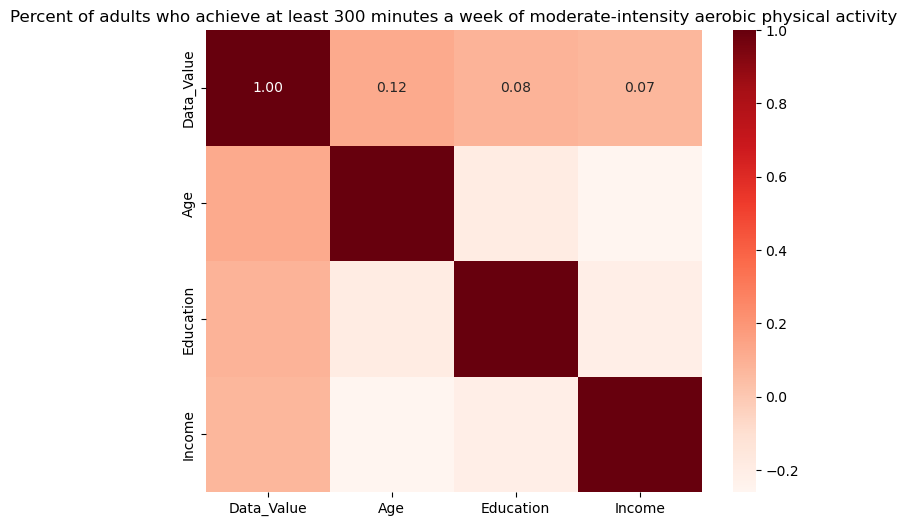

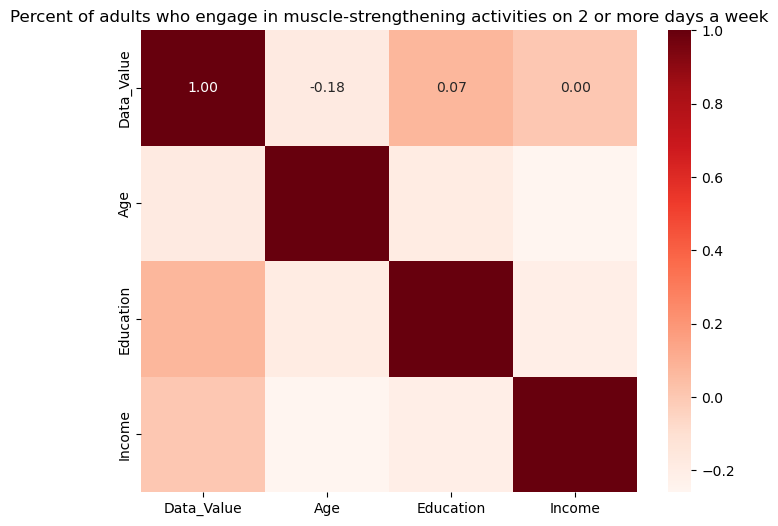

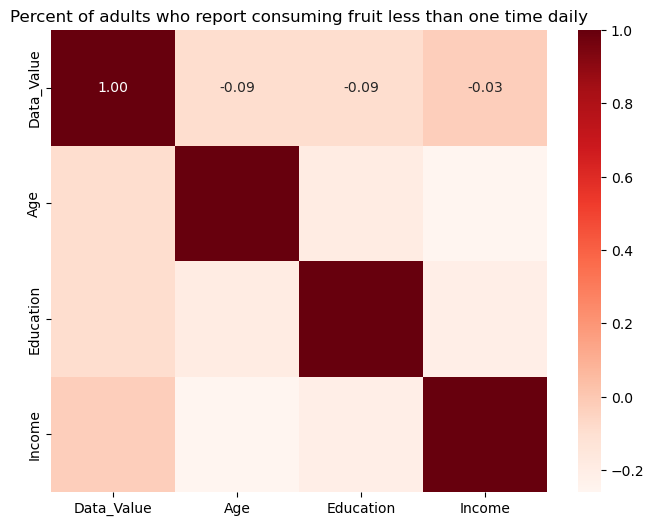

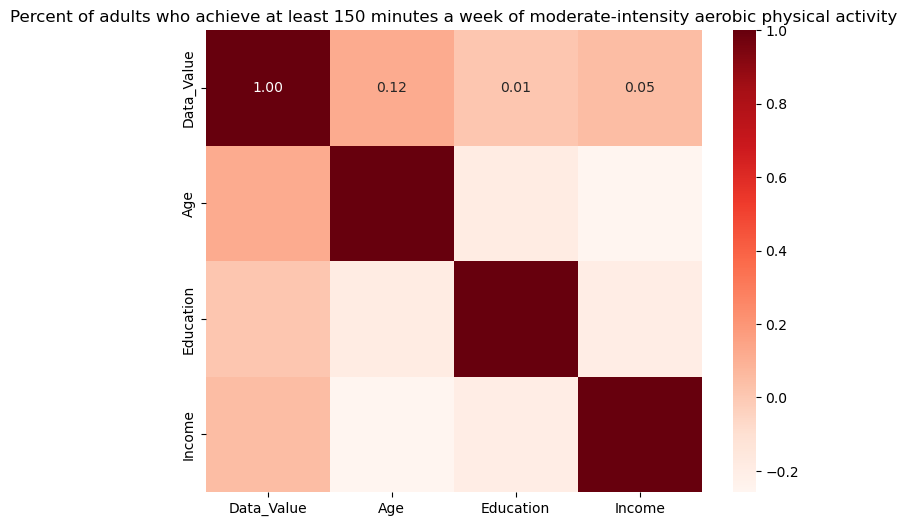

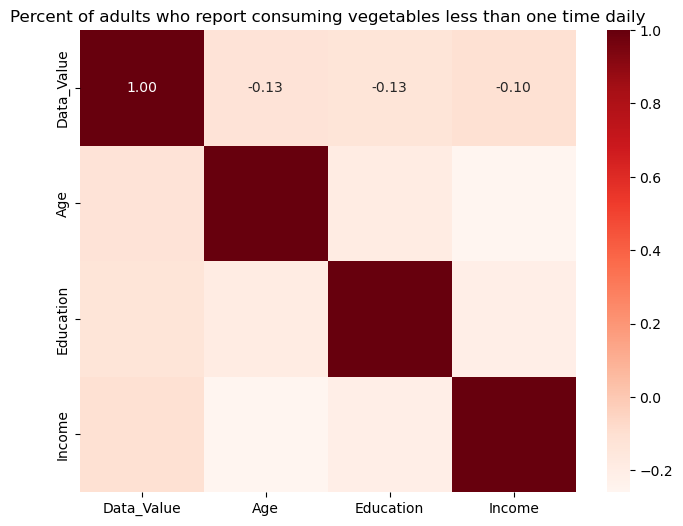

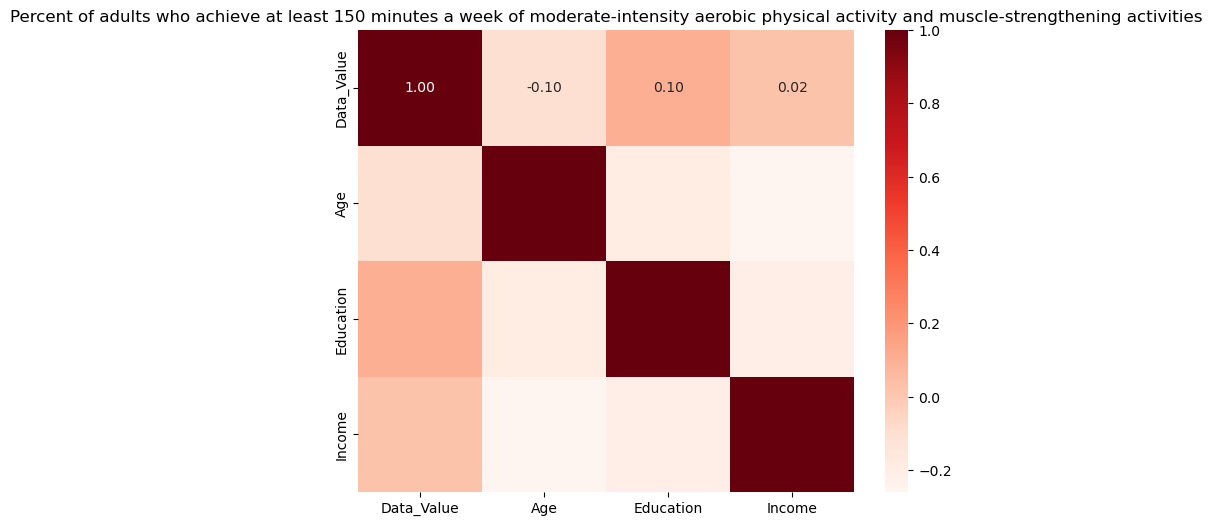

In [7]:
correlation_matrices = {}

for question_focus in questions_data.keys():
    data_specific_question = data_cleaned[data_cleaned['QuestionID'] == question_focus].copy()
    
    data_specific_question['Age'] = data_specific_question['StratificationID1'].map(age_mapping).fillna(0)
    data_specific_question['Education'] = data_specific_question['StratificationID1'].map(education_mapping).fillna(0)
    data_specific_question['Income'] = data_specific_question['StratificationID1'].map(income_mapping).fillna(0)
    
    columns_for_analysis = ['Data_Value', 'Age', 'Education', 'Income']
    data_for_correlation = data_specific_question[columns_for_analysis]

    correlation_matrix = data_for_correlation.corr()
    
    correlation_matrices[question_focus] = correlation_matrix
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="Reds", cbar=True)
    question_title = questions_data[question_focus]
    plt.title(question_title)
    plt.show()

## Models

In [8]:
for question_focus in questions_data.keys():
    data_specific_question = data_cleaned[data_cleaned['QuestionID'] == question_focus].copy()
    
    data_specific_question['Age'] = data_specific_question['StratificationID1'].map(age_mapping).fillna(0)
    data_specific_question['Education'] = data_specific_question['StratificationID1'].map(education_mapping).fillna(0)
    data_specific_question['Income'] = data_specific_question['StratificationID1'].map(income_mapping).fillna(0)
    
    X = data_specific_question[['Age', 'Education', 'Income']]
    y = data_specific_question['Data_Value']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = SVR(kernel='linear')
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    
#    print(f'Mean Squared Error for {questions_data[question_focus]}: {mse}')

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gb_regressor = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

for question_focus in questions_data.keys():
    data_specific_question = data_cleaned[data_cleaned['QuestionID'] == question_focus].copy()
    data_specific_question['Age'] = data_specific_question['StratificationID1'].map(age_mapping).fillna(0)
    data_specific_question['Education'] = data_specific_question['StratificationID1'].map(education_mapping).fillna(0)
    data_specific_question['Income'] = data_specific_question['StratificationID1'].map(income_mapping).fillna(0)
    X = data_specific_question[['Age', 'Education', 'Income']]
    y = data_specific_question['Data_Value']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    grid_search.fit(X_train_scaled, y_train)
    
    best_params = grid_search.best_params_
    best_score = np.sqrt(-grid_search.best_score_)

    y_pred = grid_search.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)

In [ ]:
scaler = StandardScaler()
data_pivoted_numeric_scaled = scaler.fit_transform(data_pivoted_numeric)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=1)
clusters = kmeans.fit_predict(data_pivoted_numeric_scaled)

data_pivoted['Cluster'] = clusters
for i in range(optimal_k):
#    print(f"Cluster {i} Summary:")
    cluster_data = data_pivoted[data_pivoted['Cluster'] == i]
    numeric_columns = data_pivoted_numeric.columns
#    print(cluster_data[numeric_columns].describe().transpose())

**Model Results**

**Support Vector Machine**
| Health Metric                                                                                       | Mean Squared Error |
|-----------------------------------------------------------------------------------------------------|-------------------:|
| Percent of adults who engage in no leisure-time physical activity                                   |            67.0769 |
| Percent of adults aged 18 years and older who have obesity                                          |            50.5076 |
| Percent of adults aged 18 years and older who have an overweight classification                     |            19.1652 |
| Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity |            37.4913 |
| Percent of adults who engage in muscle-strengthening activities on 2 or more days a week            |            51.0779 |
| Percent of adults who report consuming fruit less than one time daily                               |            39.0735 |
| Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity |            37.4522 |
| Percent of adults who report consuming vegetables less than one time daily                          |            44.6814 |
| Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity and muscle-strengthening activities |            30.7444 |  


**Gradient Boosting Regressor**
| Health Metric                                                                                       | Best Parameters                                 | Best CV RMSE | Mean Squared Error on Test Set |
|-----------------------------------------------------------------------------------------------------|-------------------------------------------------|--------------|--------------------------------|
| Percent of adults who engage in no leisure-time physical activity                                   | {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200} | 5.5871       | 30.4780                       |
| Percent of adults aged 18 years and older who have obesity                                          | {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100} | 6.0171       | 38.5927                       |
| Percent of adults aged 18 years and older who have an overweight classification                     | {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100} | 3.8628       | 14.1289                       |
| Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity | {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100} | 5.5931       | 34.0523                       |
| Percent of adults who engage in muscle-strengthening activities on 2 or more days a week            | {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100} | 5.3738       | 31.2947                       |
| Percent of adults who report consuming fruit less than one time daily                               | {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200} | 5.6151       | 31.4720                       |
| Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity | {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} | 5.4273       | 28.5198                       |
| Percent of adults who report consuming vegetables less than one time daily                          | {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100} | 5.7563       | 31.8111                       |
| Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity and muscle-strengthening activities | {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100} | 4.3870       | 17.4680                       |  


**K-Means Clustering (Q036) % of adults 18+ with obesity**
| Cluster | Count | Mean     | Std      | Min      | 25%      | 50%      | 75%      | Max      |
|---------|------:|---------:|---------:|---------:|---------:|---------:|---------:|---------:|
| 0       | 458.0 | 30.7613  | 3.6836   | 21.3481  | 27.9856  | 30.6479  | 32.9439  | 41.4667  |
| 1       |  80.0 | 27.1948  | 2.9905   | 20.5852  | 25.1763  | 26.5173  | 29.4512  | 36.0200  |
| 2       |  51.0 | 33.9058  | 2.7433   | 29.1417  | 32.0123  | 33.9960  | 35.9364  | 41.0955  |


**Analysis and Conclusions**  
Based off the results we know different things, the insights from K-Means Clustering is different from the supervised models. K-Means Clustering is able to identify distinct groups with high mean obesity rates of approximately 27.2%, 30.8% and 33.9%. Which could be good information for public health interventions. Unlike the other two models it does not offer a direct comparison or have predictive capabilities like the SVM or Gradient Boosting Regressor.  
The Gradient Boosting Regressor performed better than the SVM at the best model having a MSE 14.13 compared to the 19.17 on the SVM. This is somewhat to be expected because the GBR was hyperparameter tuned.